<div align="center">
    <img src="https://www.universidades.com.ec/logos/original/logo-universidad-politecnica-salesiana.png">
    <h1 style="text-align: center;"><span style="text-align: center; color: #0000ff;"><strong>TAREA 7 DE SIMULACION</strong></span></h1>
    <p style="text-align: center;"><span style="text-align: center;"><strong>ESTUDIANTE: ANGEL RUIZ</strong></span></p>
</div>

<h2>
	<span style="color: #00ff00;">
		 Importaci&oacute;n de librerias
	</span>
</h2>
<p>
	<span>
	</span>
	 A continuaci&oacute;n se importaran todas las librer&iacute;as que se utilizaran en el proceso del
	<span class="misspelling correction" data-type="misspelling" data-suggestions="[{&quot;value&quot;:&quot;an&aacute;lisis&quot;},{&quot;value&quot;:&quot;ana lisis&quot;}]" data-rule="MORFOLOGIK_RULE_ES" title="Se ha encontrado un posible error ortogr&aacute;fico." data-word="analisis">
		 an&aacute;lisis
	</span>
	 y simulaci&oacute;n de los datos.
</p>

In [1]:
import pandas as pd
import json, os
from mpl_toolkits.mplot3d import Axes3D
import random       
from matplotlib import pyplot 
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import altair as alt
import altair_viewer
import plotly.express as px
import plotly
plotly.offline.init_notebook_mode(connected=True)
import datetime as dt
import simpy
from datetime import datetime

<h2><span style="color: #00ff00;">Simulación Covid</span></h2>
<p>Creamos una simulación de un recinto de vacunación, específicamente seleccioné el de colisión Jefferson Pérez, para ello primero definimos todas las variables globales que utilizaremos </p>

In [2]:
NUM_VACUNAS = 80
NUM_PERSONAS_VACUNANDO = 5
NUM_TOMANDO_DATOS = 5
NUM_CERTIFICADO = 5
TIEMPO_SIM = 540
TIEMPO_ESPERA = 0
INVERTAVALO = 5
DATE_SECOND = datetime.now().strftime('%Y/%m/%d')
List = []

Para realizar la simulacion vamos a utilizar clases ya que nos permite tener de forma ordenada nuestro codigo, teniendo en cuenta vamos a realizar las siguientes clases.

* Persona: El ciudadano a vacunar
* Vacunacion: Proceso de vacunacion
* Simulacion : Realiza la simulacion
* ProblemaExamen: Clase Exception

<h2>Una vez definidas nuestras clases, codificamos toda la logica de nuestra simulación</h2>

In [3]:
class ProblemaExamen(Exception):
    pass


class Persona():
    def __init__(self, nombre='', problema=0):
        self.nombre = nombre
        self.problema = problema
        self.cite = ''


class VacunaException(Exception):
    pass


class Vacunacion():
    def __init__(self, entorno):
        global NUM_PERSONAS_VACUNANDO, NUM_CERTIFICADO, NUM_TOMANDO_DATOS, NUM_VACUNAS
        self.entorno = entorno
        self.persona_v = simpy.Resource(entorno, NUM_PERSONAS_VACUNANDO)
        self.persona_e = simpy.Resource(entorno, NUM_TOMANDO_DATOS)
        self.persona_c = simpy.Resource(entorno, NUM_CERTIFICADO)
        self.vacunas = NUM_VACUNAS
        self.examen = None
        self.probabilidad = [0.8, 0.2]
        self.examen_result = [0, 1]

    def print_process(self, persona, hora, accion):
        print(
            'Persona:[{}] - hora:[{:,.2f}] - accion [{}].'.format(persona, hora, accion))

    def proceso_examen(self, tiempo):
        self.examen = random.choices(
            self.examen_result, self.probabilidad, k=1)
        yield self.entorno.timeout(tiempo)

    def datos_certificados(self, tiempo):
        yield self.entorno.timeout(tiempo)

    def vacunacion_persona(self, tiempo):
        self.vacunas = self.vacunas-1
        yield self.entorno.timeout(tiempo)

    def proceso_certifcado(self, tiempo):
        yield self.entorno.timeout(tiempo)

    def proceso_salida(self, tiempo):
        yield self.entorno.timeout(tiempo)

    def proceso_vacunacion(self, persona):
        global List
        tiempo_examen = 0
        tiempo_datos = 0
        tiempo_vacuna = 0
        tiempo_certificado = 0
        tiempo_salida = 0
        resultado_vacuna = 0
        tiempo_espera = 0

        self.print_process(persona.nombre, self.entorno.now,
                           'Llega al recinto')
        espera = self.entorno.now
        with self.persona_e.request() as mesa:
            yield mesa
            self.print_process(
                persona.nombre, self.entorno.now, 'Llego a la mesa')
            self.print_process(persona.nombre, self.entorno.now,
                               'Entra al proceso de examen')
            tiempo_espera = self.entorno.now - espera
            tiempo_examen = 20

            yield self.entorno.process(self.proceso_examen(tiempo_examen))

        try:
            if(self.examen[0] == 0):
                resultado_vacuna = 1
                self.print_process(
                persona.nombre, self.entorno.now, 'Paso el proceso de revisión')

                with self.persona_c.request() as certificado:
                    self.print_process(persona.nombre, self.entorno.now, 'Entra al proceso de toma de datos')
                    yield certificado
                    tiempo_datos = random.randint(2, 4)
                    yield self.entorno.process(self.datos_certificados(tiempo_datos))
                    self.print_process(persona.nombre, self.entorno.now, 'Se tomaron los datos')

                    with self.persona_v.request() as vacunacion:
                        yield vacunacion

                        try:
                            if(self.vacunas > 0):
                                self.print_process(
                                persona.nombre, self.entorno.now, 'Llegó a la vacunacion')
                                tiempo_vacuna = random.randint(5, 10)
                                yield self.entorno.process(self.vacunacion_persona(tiempo_vacuna))
                                self.print_process(
                                persona.nombre, self.entorno.now, 'Vacunacion correcta')

                                tiempo_certificado = random.randint(1, 3)
                                yield self.entorno.process(self.proceso_certifcado(tiempo_certificado))
                                persona.cite = datetime.strftime(datetime.strptime(DATE_SECOND, '%Y/%m/%d')+dt.timedelta(days=21), '%Y/%m/%d')
                                self.print_process(
                                persona.nombre, self.entorno.now, 'Se entrega el certicado, la siguiente cita es {}'.format(persona.cite))
                            else:
                                raise VacunaException
                        except VacunaException:
                            persona.cite = datetime.strftime(datetime.strptime(DATE_SECOND, '%Y/%m/%d')+dt.timedelta(days=1), '%Y/%m/%d')
                            resultado_vacuna = 0
                            self.print_process(
                            persona.nombre, self.entorno.now, 'No se realizo la vacunacion, Proxima fecha {}'.format(persona.cite))
            else:
                raise ProblemaExamen
        except ProblemaExamen:
            persona.cite = datetime.strftime(datetime.strptime(DATE_SECOND,'%Y/%m/%d')+dt.timedelta(days=random.randint(2,5)),'%Y/%m/%d')
            resultado_vacuna = 0
            self.print_process(persona.nombre, self.entorno.now, 'No pasó el proceso de vacunacion, Proxima fecha {}'.format(persona.cite))
        tiempo_salida = random.randint(1,5)
        self.entorno.process(self.proceso_salida(tiempo_salida))
        self.print_process(persona.nombre, self.entorno.now, 'Sale del recinto')
        List.append((persona.nombre,tiempo_examen,tiempo_datos,tiempo_vacuna,tiempo_certificado,tiempo_salida,tiempo_espera,resultado_vacuna))
            
class Simulacion():
    def __init__(self, personas_simulacion):
        self.personas_simulacion = personas_simulacion
        self.nombre = 'persona_{}'
    
    def lanzarSimulacion(self,entorno):
        global INVERTAVALO
        vacunacion = Vacunacion(entorno)
    
        self.iniciarPersona(entorno,vacunacion)
        
        while True:
            yield entorno.timeout(random.randint(INVERTAVALO-1, INVERTAVALO))
            nombre = self.nombre.format(self.personas_simulacion)
            persona = Persona(nombre)
            entorno.process(vacunacion.proceso_vacunacion(persona))
            self.personas_simulacion+=1
    
    def iniciarPersona(self,entorno,vacunacion):
        for i in range(self.personas_simulacion):
            nombre = self.nombre.format(i)
            persona = Persona(nombre)
            entorno.process(vacunacion.proceso_vacunacion(persona))
            


<h2>Ejecutamos nuestra simulación</h2>

In [4]:
entorno = simpy.Environment()
simulacion = Simulacion(7)
entorno.process(simulacion.lanzarSimulacion(entorno))
entorno.run(until=TIEMPO_SIM)

Persona:[persona_0] - hora:[0.00] - accion [Llega al recinto].
Persona:[persona_1] - hora:[0.00] - accion [Llega al recinto].
Persona:[persona_2] - hora:[0.00] - accion [Llega al recinto].
Persona:[persona_3] - hora:[0.00] - accion [Llega al recinto].
Persona:[persona_4] - hora:[0.00] - accion [Llega al recinto].
Persona:[persona_5] - hora:[0.00] - accion [Llega al recinto].
Persona:[persona_6] - hora:[0.00] - accion [Llega al recinto].
Persona:[persona_0] - hora:[0.00] - accion [Llego a la mesa].
Persona:[persona_0] - hora:[0.00] - accion [Entra al proceso de examen].
Persona:[persona_1] - hora:[0.00] - accion [Llego a la mesa].
Persona:[persona_1] - hora:[0.00] - accion [Entra al proceso de examen].
Persona:[persona_2] - hora:[0.00] - accion [Llego a la mesa].
Persona:[persona_2] - hora:[0.00] - accion [Entra al proceso de examen].
Persona:[persona_3] - hora:[0.00] - accion [Llego a la mesa].
Persona:[persona_3] - hora:[0.00] - accion [Entra al proceso de examen].
Persona:[persona_4]

<h2>Con los datos obtenidos de nuestra simulación, creamos un DataFrame para su facil tratamiento</h2>

In [5]:
df_data = pd.DataFrame(List, columns=['nombre','tiempo_exam','tiempo_datos','tiempo_vacuna','tiempo_certificado','tiempo_salida', 'tiempo_espera' , 'resultado_vacuna'])
df_data['id'] = df_data['nombre'].apply(lambda x:int(x.split('_')[1]))
df_data.set_index('id', inplace=True)
df_data.reset_index(inplace=True)
df_data = df_data.convert_dtypes()
df_data['tiempo_total'] = df_data['tiempo_exam']+df_data['tiempo_datos']+df_data['tiempo_vacuna']+df_data['tiempo_certificado']+df_data['tiempo_salida']
df_data.head()

,id,nombre,tiempo_exam,tiempo_datos,tiempo_vacuna,tiempo_certificado,tiempo_salida,tiempo_espera,resultado_vacuna,tiempo_total
0,0,persona_0,20,0,0,0,3,0,0,23
1,1,persona_1,20,0,0,0,1,0,0,21
2,2,persona_2,20,0,0,0,5,0,0,25
3,3,persona_3,20,0,0,0,3,0,0,23
4,4,persona_4,20,0,0,0,3,0,0,23


<h2><span style="color: #00ff00;">Gráficos</span></h2>

<h2>Total de de personas que realizaron el proceso de vacunación.</h2>

In [6]:
alt.Chart(df_data[df_data['resultado_vacuna']==1]).mark_bar(color='orange').encode(
    x=alt.X('nombre',sort=alt.EncodingSortField(field="id", op="count", order='ascending')),
    y='tiempo_total'
    )+alt.Chart(df_data[df_data['resultado_vacuna']==1]).mark_point(color='green').encode(
        x=alt.X('nombre',sort=alt.EncodingSortField(field="id", op="count", order='ascending')),
        y='tiempo_total').properties(title='Tiempo total - Recinto Jefferson Perez').interactive()

alt.LayerChart(...)

<h2>Grafico del porcentaje de personas que no recibieron la vacuna.</h2>

In [7]:
dict_vacunas = {'vacunados':['Si','No'],
               'values':[df_data.query('resultado_vacuna == "1"').count()[0]/len(df_data),
                         df_data.query('resultado_vacuna == "0" ').count()[0]/len(df_data)]}
dict_vacunas=pd.DataFrame(dict_vacunas)
dict_vacunas

,vacunados,values
0,Si,0.655738
1,No,0.344262


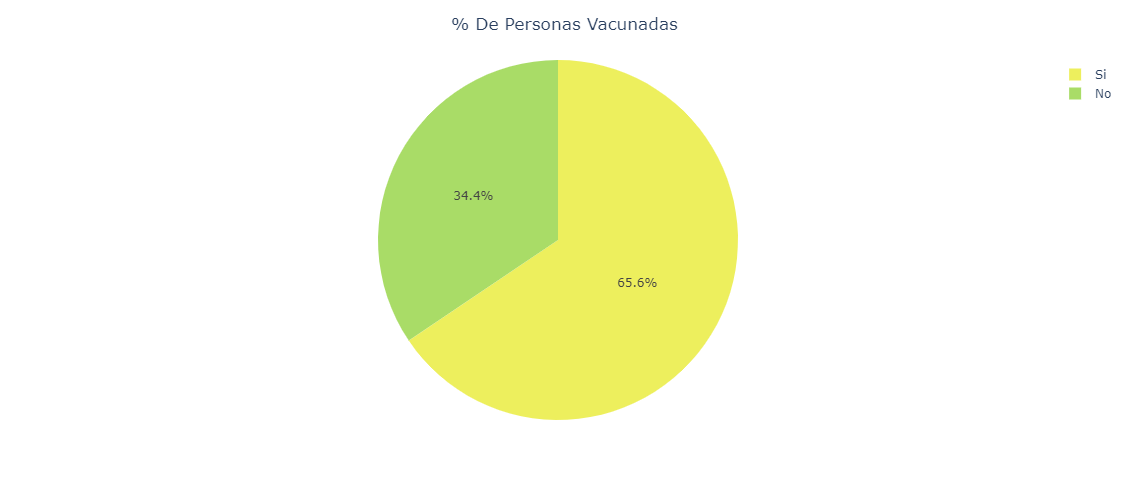

In [8]:
fig = px.pie(dict_vacunas, values="values",
             names="vacunados", 
             color_discrete_sequence=px.colors.sequential.Aggrnyl_r,width=500,height=500)
fig.update_layout(title_text='% De Personas Vacunadas', title_x=0.5)

<h2>Tiempo promedio de espera.</h2>

In [9]:
print('Tiempo promedio de la espera es de {:.2f}'.format(df_data['tiempo_espera'].mean()))

Tiempo promedio de la espera es de 2.36


In [10]:
alt.Chart(df_data[df_data['resultado_vacuna']==1]).mark_bar(color='orange').encode(
    x=alt.X('nombre',sort=alt.EncodingSortField(field="id", op="count", order='ascending')),
    y='tiempo_espera'
    )+alt.Chart(df_data[df_data['resultado_vacuna']==1]).mark_point(color='green').encode(
        x=alt.X('nombre',sort=alt.EncodingSortField(field="id", op="count", order='ascending')),
        y='tiempo_espera').properties(title='Tiempo de espera - Recinto Jefferson Perez').interactive()

alt.LayerChart(...)